In [1]:
from boututils.datafile import DataFile
from boutdata.collect import collect
from boutdata.data import BoutData
import os, sys
import matplotlib
# matplotlib.use('Qt5Agg',force=True)
# matplotlib.use("TKAgg",force=True)
# matplotlib.use("widget",force=True)
import matplotlib.pyplot as plt
import xbout
import pandas as pd
import numpy as np
import pickle as pkl
import xarray as xr
import boutdata

from boutdata.restart import addvar
import glob
import shutil

import scipy

sys.path.append(r"/ssd_scratch/scripts/sdtools")


from hermes3.case_db import *
from hermes3.load import *
from hermes3.named_selections import *
from hermes3.plotting import *
from hermes3.grid_fields import *
from hermes3.accessors import *
from hermes3.utils import *
from cli.cmonitor import *
# from code_comparison.code_comparison import *


%load_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
db = CaseDB(
    case_dir = r"/ssd_scratch/hcases",
    grid_dir = r"/ssd_scratch/hcases"
    )

toload = [ 
    # dict(name="base", id="faf6a-newbase_faf5y1_tightrtol_long", unnormalise_geom = True, use_xhermes = True, squash = False), 
    # dict(name="legcond_bool", id="faf8c-asymp2_lifreeze_kappa", unnormalise_geom = True, use_xhermes = True, squash = False), 
    dict(name="test", id="faf8c-asymp2_lifreeze_kappa", unnormalise_geom = True, use_xhermes = True, squash = False), 
]
cs = {}
for case in toload:
    cs[case["name"]] = db.load_case_2D(case["id"], use_squash = case["squash"], verbose = True)


- Reading case faf8c-asymp2_lifreeze_kappa
-----------------------


/ssd_scratch/scripts/xBOUT/xbout/load.py:1138: UserWarning: Will drop all variables containing the dimensions 't' because they are not recognised
  warn(



Unnormalising with xHermes


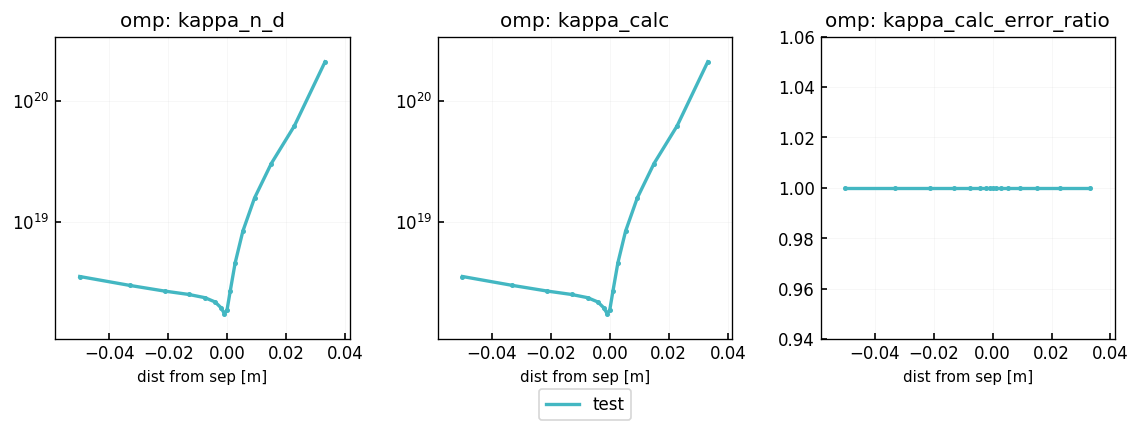

In [6]:
toplot = {}
for case in cs:
# for case in ["test_legacy", "test_afn"]:

    ds = cs[case].ds
    ds["kappa_ratio"] = ds["kappa_n_d"] / ds["kappa_n_unlimited_d"]
    ds["kappa_unlim_calc"] = ds["Dnn_unlimd"] * ds["Nd"] * 5/2
    ds["kappa_unlim_calc_error"] = ds["kappa_n_unlimited_d"] / ds["kappa_unlim_calc"]
    
    gamma = 2
    ds["kappa_calc"] = ds["kappa_n_unlimited_d"] * (1 + (ds["kappa_n_unlimited_d"]/ds["kappa_n_max_d"])**(gamma))**(-1/gamma)
    ds["kappa_calc_error_ratio"] = ds["kappa_calc"] / ds["kappa_n_d"]
    if "t" in ds.dims: ds = ds.isel(t=-1)
    toplot[case] = ds.isel(x = slice(2,-2))

    
lineplot(
    toplot,
    clean_guards = False,
    logscale = True,
    # params = ["kappa_n_d", "kappa_n_unlimited_d", "Nd", "Dnnd", "kappa_n_max_d", "Dnn_unlimd"],
    params = ["kappa_n_d", "kappa_calc", "kappa_calc_error_ratio"],
    # params = ["Nd", "Dnnd"],
    # regions = ["omp", "imp", "outer_lower", "field_line"],
    regions = ["omp"]
)

In [ ]:
  alternative_precon = options["alternative_precon"]
                          .doc("Use alternative preconditioner?")
                          .withDefault<bool>(false);



  if (alternative_precon) {
    coef = -gamma * Dnn - gamma * kappa_n;
    inv->setCoefD(coef);
  }



In [4]:
[print(x) for x in ds.data_vars if "kappa" in x]

kappa_d
kappa_n_Dnchained_d
kappa_n_d
kappa_n_max_d
kappa_n_unlimited_d
kappa_par_d+
kappa_par_e
kappa_ratio
kappa_unlim_calc
kappa_unlim_calc_error


[None, None, None, None, None, None, None, None, None, None]

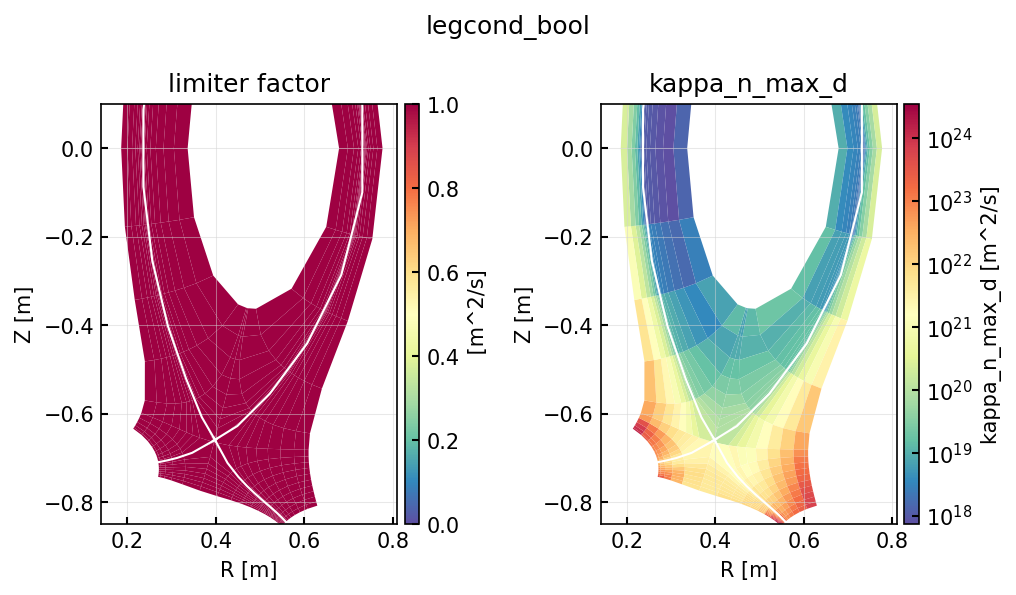

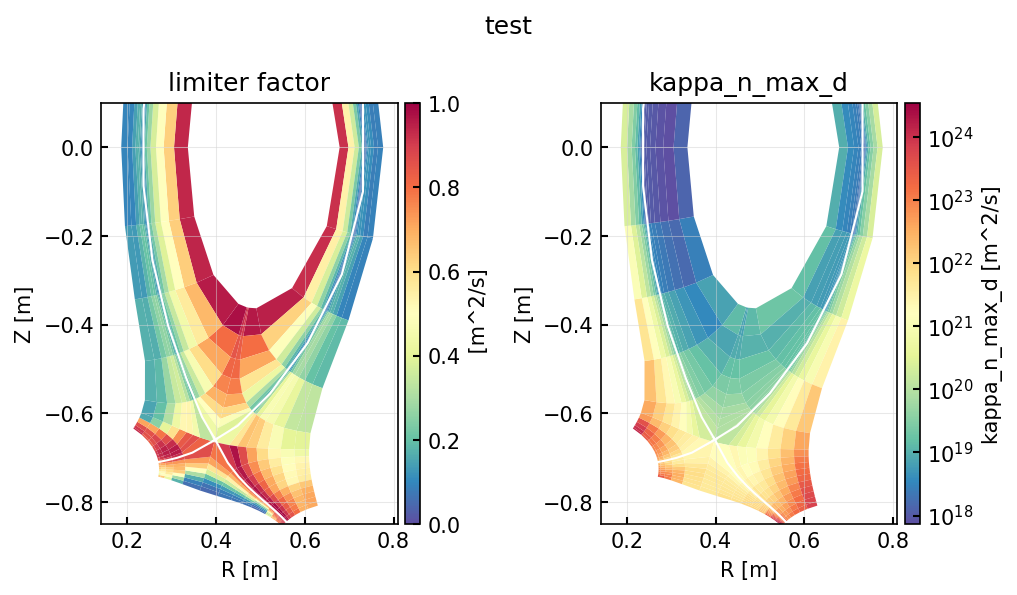

In [10]:
# for case in ["a1_mfp1e-4"]:
for case in cs:
# for case in ["base", "no_rnn_flim1"]:

    ds = cs[case].ds
    if "t" in ds.dims: ds = ds.isel(t=-1)
    plot2d(
        [
            dict(data = ds["kappa_n_d"] / ds["kappa_n_unlimited_d"], title = "limiter factor", vmin = 0, vmax = 1, logscale = False),
            dict(data = ds["kappa_n_max_d"] , vmin = None, vmax = None),

            ], 
            ylim = (-0.85, 0.1),
            title = f"{case}")

In [ ]:
G = np.linspace(0,2000, 5000)
Gmax = 1000
gamma = 1

def make_glim(gamma):
    return G * (1 + (G/Gmax)**gamma)**(-1/gamma)


# plt.hlines(2000, G[0], G[-1], label = "Max", ls = "--", colors = "black")
plt.hlines(Gmax, G[0], G[-1], label = "Limit", ls = ":", colors = "black")
plt.vlines(Gmax, 0, Gmax, ls = ":", colors = "black")

plt.plot(G, make_glim(1), label = "gamma = 1")
plt.plot(G, make_glim(2), label = "gamma = 2")
plt.plot(G, make_glim(5), label = "gamma = 4")
plt.plot(G, make_glim(10), label = "gamma = 10")

plt.xlabel("Flux")
plt.legend(loc = "upper left", bbox_to_anchor=(1,1))
plt.ylabel("Limited flux")

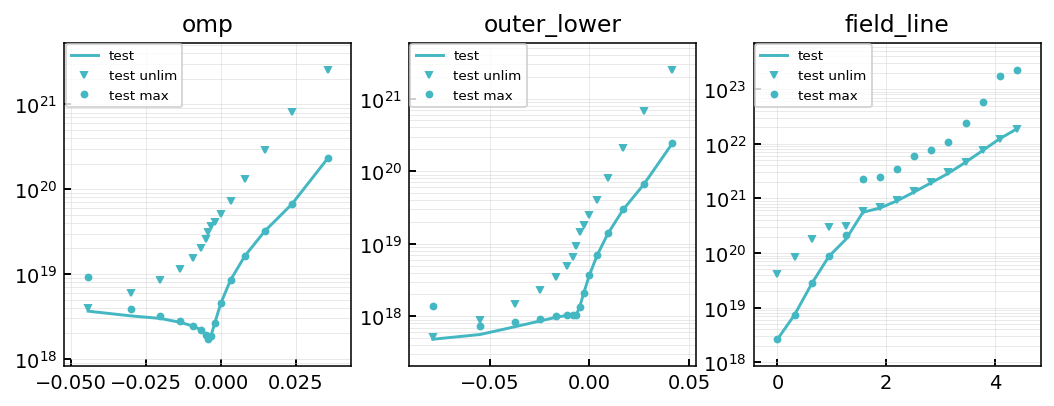

In [3]:
fig, axes = plt.subplots(1,3, figsize = (9,3))

colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]


for i, case in enumerate(cs):
# for i, case in enumerate(["base"]):

    ds = cs[case].ds
    if "t" in ds.dims: ds = ds.isel(t=-1)

    regions = dict(
        omp = ds.hermesm.select_region("outer_midplane_a").isel(x=slice(2,-2)).squeeze(),
        outer_lower = ds.hermesm.select_region("inner_midplane_a").isel(x=slice(2,-2)).squeeze(),
        field_line = ds.hermesm.select_custom_sol_ring(ds.metadata["ixseps1"], "outer_lower").squeeze()
    )

    

    for j, region in enumerate(regions):
        reg = regions[region]

        if region == "field_line":
            dist = reg.coords["theta"] - reg.coords["theta"][0]
        else:
            R = reg["dr"].cumsum()
            dist = (R - R[ds.metadata["ixseps1"]])

        ax = axes[j]
        ax.plot(dist, reg["kappa_n_d"], color = colors[i], label = f"{case}")
        ax.plot(dist, reg["kappa_n_unlimited_d"], color = colors[i], marker = "v", lw = 0, ms = 3,  label = f"{case} unlim")
        if case != "base": ax.plot(dist, reg["kappa_n_max_d"], color = colors[i], marker = "o", lw = 0, ms = 3, label = f"{case} max")
        ax.set_title(region)
        # ax.plot(dist, reg["kappa_n_Dnchained_d"], color = colors[i], marker = "o", lw = 0, ms = 3, label = f"{case} max")

        ax.legend(fontsize = "x-small")
        ax.set_yscale("log")

